In [1]:
import skimage.io as io
import skimage as sk
from skimage.color import rgb2gray
from skimage.transform import resize
import time
import numpy as np
import os


from unitTesting import UnitTest
import adaboost.adaboost as ab
import utilitis as ut

# Unit Testing

In [2]:
img = io.imread('./test.jpg')
img = rgb2gray(img)
unitTesting = UnitTest(img)

Integral image test PASSED
Total number of features = 273312
Determine features test FAILED. No of features : 273,312
Calculate sum test 1 PASSED
Calculate sum test 2 PASSED
Calculate sum test 3 PASSED
Feature value test 1 PASSED
Feature value test 2 PASSED


# Getting Datasets

In [3]:


#load positive dataset
try:
    print("Loading positive dataset...")
    positiveDataset = np.load("./Dataset/posTrain.npy")
except:
    print("No dataset found, creating new dataset...")
    positiveDataset = np.load("./Dataset/olivetti_faces.npy")
    personID = np.load("./Dataset/olivetti_faces_target.npy")


    #resize images to 24x24
    newPositiveDataset = np.empty(shape=(positiveDataset.shape[0], 24, 24))
    for i in range(len(positiveDataset)):
        newImg = np.array(positiveDataset[i])
        
        finalImg = resize(newImg, (24, 24))
        newPositiveDataset[i] = finalImg

    positiveDataset = newPositiveDataset

    # for i in range(10):
    #     io.imshow(positiveDataset[i])
    #     io.show()

    # print(positiveDataset.shape)

    

    # np.save("./Dataset/positiveDataset.npy", positiveDataset)
    # print("Positive Dataset saved")

#loading negative dataset
try:
    print("Loading negative dataset...")
    negativeDataset = np.load("./Dataset/negTrain.npy")
except:
    print("No dataset found, creating new dataset...")
    directory = "./Dataset/NegativeSet"
    negativeDataset = np.empty(shape=(len(os.listdir(directory)), 24, 24))
    i = 0
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            curImg = io.imread(os.path.join(directory, filename), as_gray=True)
            newImg = resize(curImg, (24, 24))
            negativeDataset[i] = newImg
            i += 1
    # negativeDataset = negativeDataset.reshape(len(os.listdir(directory)), 64, 64)
    # print(negativeDataset.shape)
    # np.save("./Dataset/negativeDataset.npy", negativeDataset)
    # print("Negative Dataset saved")



posDataset, negDataset = ut.preprocessImages(positiveDataset, negativeDataset)

print(f"Positive Dataset Shape: {posDataset.shape}")
print(f"Negative Dataset Shape: {negDataset.shape}")



Loading positive dataset...
Loading negative dataset...
Positive Dataset Shape: (300, 24, 24)
Negative Dataset Shape: (240, 24, 24)


# Training

In [4]:
minFeatureWidth = 4
maxFeatureWidth = 16
minFeatureHeight = 4
maxFeatureHeight = 16
nClassifiers = 50
threshold = 0

classifiersToBeUsed = []
try :
    print("Loading classifiers...")
    classifiersToBeUsed = np.load("./classifiers.npy", allow_pickle=True)
except Exception as e:
    # print(e)
    print("No classifiers found, creating new classifiers...")
    classifier = ab.AdaBoost()
    start = time.time()
    classifiersToBeUsed = classifier.learn(posDataset, negDataset,threshold,minFeatureWidth,minFeatureHeight,maxFeatureWidth,maxFeatureHeight, nClassifiers)
    end = time.time()
    classifiersToBeUsed = np.array(classifiersToBeUsed)
    np.save("./classifiers.npy", classifiersToBeUsed)
    print("Time taken to train the classifier: ", end-start)

print("Classifiers loaded successfully")








Loading classifiers...
No classifiers found, creating new classifiers...
Calculating integral images...
Done!

Creating initial weights and labels...
Done!

Calculating all possible haar features...
Total number of features = 121992
Done!

Calculating votes of all haar features for all samples...
Done!

Training 121992 classifiers...
 Training classifier 50 of 50...Time taken to train the classifier:  762.3854877948761
Classifiers loaded successfully


# Testing

Test Dataset Shape: (160, 24, 24)
Predicted:  0
Target:  1


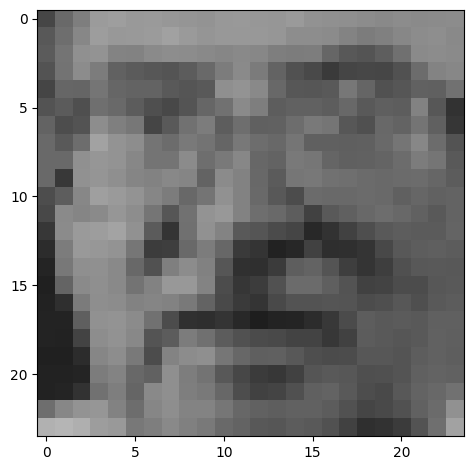

Predicted:  0
Target:  1


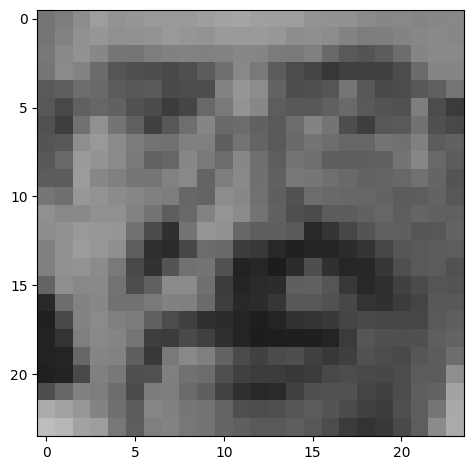

Predicted:  0
Target:  1


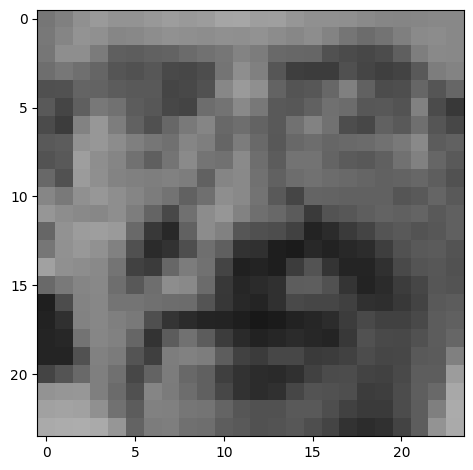

Predicted:  0
Target:  1


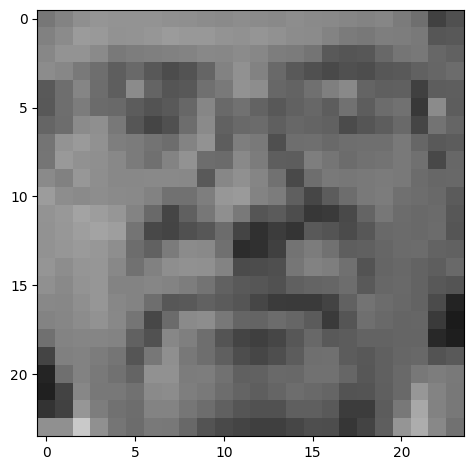

Predicted:  1
Target:  0


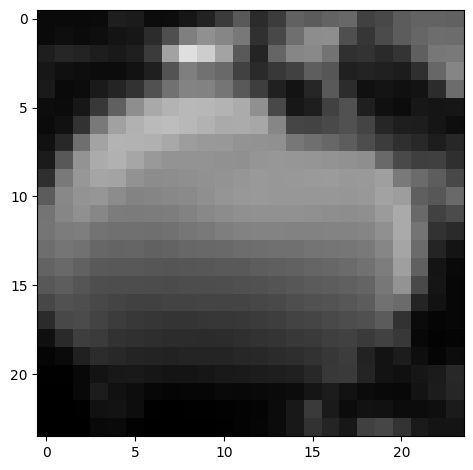

Accuracy:  96.875 %
Faces detected: 96 / 100 , Accuracy: 96.0%
Non Faces detected: 59 / 60 , Accuracy: 98.33333333333333%


In [9]:
testDataSet = np.load("./Dataset/testMix.npy")
testDataSetTarget = np.load("./Dataset/testTargets.npy")
#convert to int 
testDataSetTarget = testDataSetTarget.astype(int)

print(f"Test Dataset Shape: {testDataSet.shape}")

#get integral images
ii = np.array([ut.integralImage(test) for test in testDataSet])

i = 0
correctCount = 0
firstWrong = 5
facesCount = 0
correctFacesCount = 0
correctNonFacesCount = 0
nonFacesCount = 0
for test in ii:
    predicted = ut.getVotes(np.array(classifiersToBeUsed), test)
    if predicted == testDataSetTarget[i]:
        correctCount += 1
        if predicted == 1:
            correctFacesCount += 1
        else:
            correctNonFacesCount += 1
    else:
        if firstWrong > 0:
            print("Predicted: ", predicted)
            print("Target: ", testDataSetTarget[i])
            io.imshow(testDataSet[i])
            io.show()
            firstWrong -= 1
    if testDataSetTarget[i] == 1:
        facesCount += 1
    if testDataSetTarget[i] == 0:
        nonFacesCount += 1
    
    i += 1

print("Accuracy: ", correctCount/len(testDataSet) * 100, "%")
print(f"Faces detected: {correctFacesCount} / {facesCount} , Accuracy: {correctFacesCount/facesCount * 100}%")
print(f"Non Faces detected: {correctNonFacesCount} / {nonFacesCount} , Accuracy: {correctNonFacesCount/nonFacesCount * 100}%")